<a href="https://www.kaggle.com/code/cirillafiona/hw2-indian-pine?scriptVersionId=126784622" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.io import loadmat
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/indian-pines/Indian_pines_corrected.mat
/kaggle/input/indian-pines/Indian_pines_gt.mat


In [2]:
# # Kaggle运行使用
def LoadData():
    data_path = '../input/'
    data = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_gt.mat'))['indian_pines_gt']  
    return data, labels

In [3]:
# # 本地运行使用
# def LoadData():
#     data_path = './data/'
#     data = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_corrected.mat'))['indian_pines_corrected']
#     labels = loadmat(os.path.join(data_path, 'indian-pines/Indian_pines_gt.mat'))['indian_pines_gt']

In [4]:
if __name__ == '__main__':
    # 读取数据
    data, labels = LoadData()
    
    # 删除标签为0的数据
    data = data[labels != 0]
    labels = labels[labels != 0]
    # 将标签从1开始重新编号
    labels -= 1
    
    X = data.reshape(-1, 200)
    y = labels.reshape(-1, )
    standard_scaler = StandardScaler()
    X = standard_scaler.fit_transform(X)

#     进行PCA降维
    pca_dims = 100
    pca = PCA(n_components=pca_dims)
    X_pca = pca.fit_transform(X)
    print(pca.explained_variance_ratio_.sum())
    print(X_pca.shape)


    # 使用10折交叉验证评估模型性能
    max_iter = -1
    svm_kernel = "rbf"
    skf = StratifiedKFold(n_splits=10,random_state=2,shuffle=True)
    accuracy = []
    clf = SVC(kernel=svm_kernel, C=100, gamma='auto', max_iter=max_iter)
    clf.n_jobs = -1 #没用
    for train_index, test_index in skf.split(X_pca, y):
        # 将数据分为训练集和测试集
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 训练SVM分类器
        clf.fit(X_train, y_train)

        # 预测
        label_train_pre = clf.predict(X_train)
        y_pred = clf.predict(X_test)

        # 计算模型性能
        train_pre = precision_score(y_train, label_train_pre, average='micro')
        test_pre = precision_score(y_test, y_pred, average='micro')
        train_recall = recall_score(y_train, label_train_pre, average='micro')
        test_recall = recall_score(y_test, y_pred, average='micro')

        print("max_iter: %d, pca_dims: %d, svm_kernel: %s" % (max_iter, X_pca.shape[1], svm_kernel))
        print("train: pre: {:.3%}, recall: {:.3%},  test: pre: {:.3%}, recall: {:.3%}".format(train_pre, train_recall, test_pre, test_recall))

        acc = accuracy_score(y_test, y_pred)
        accuracy.append(acc)

    # 输出模型性能报告
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
    y_pred_pca = clf.predict(X_pca)
    print(classification_report(y, y_pred_pca))
    cm = confusion_matrix(y, y_pred_pca)
    print(cm)

0.9988258690891462
(10249, 100)
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.556%, recall: 99.556%,  test: pre: 91.707%, recall: 91.707%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.686%, recall: 99.686%,  test: pre: 89.366%, recall: 89.366%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.642%, recall: 99.642%,  test: pre: 91.610%, recall: 91.610%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.642%, recall: 99.642%,  test: pre: 90.634%, recall: 90.634%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.621%, recall: 99.621%,  test: pre: 92.000%, recall: 92.000%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.610%, recall: 99.610%,  test: pre: 92.976%, recall: 92.976%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.631%, recall: 99.631%,  test: pre: 90.732%, recall: 90.732%
max_iter: -1, pca_dims: 100, svm_kernel: rbf
train: pre: 99.653%, recall: 99.653%,  test: pre: 91.902%, recall: 91.902%
max_iter

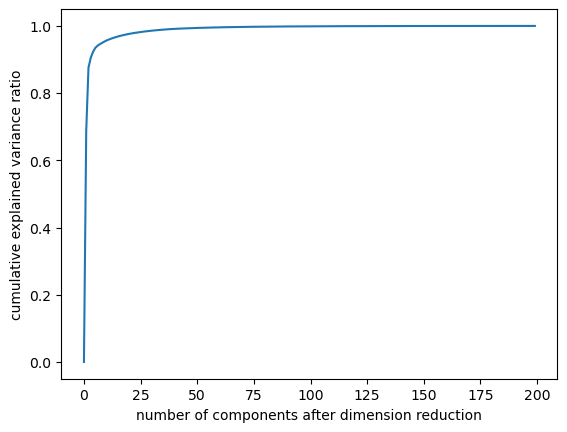

In [5]:
    # 绘制随着n_components变化累计可解释方差比的变化
    evrs = []
    for n in range(0, 200, 1):
        pca = PCA(n_components=n)
        X_pca2 = pca.fit_transform(X)
        evr = pca.explained_variance_ratio_.sum()
        evrs.append(evr)
    plt.plot(range(0, 200, 1), evrs)
    plt.xlabel("number of components after dimension reduction")# 降维后维度数量
    plt.ylabel("cumulative explained variance ratio")# 累计可解释方差比
    plt.show()

In [6]:
#     # 绘制标签(去除背景类这样画图有问题)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(labels, cmap='jet')
#     plt.axis('off')
#     plt.colorbar(ticks= range(0,16))
#     plt.title("Labels")
#     plt.show()
    
#     # 绘制所有数据的预测结果
# #     y_pred_pca = clf.predict(X_pca)
#     Y_pred2 = y_pred_pca.reshape(145, 145)
#     plt.figure(figsize=(8, 6))
#     plt.imshow(Y_pred2, cmap='jet')
#     plt.axis('off')
#     plt.colorbar(ticks= range(0,16))
#     plt.title("Results")
#     plt.show()

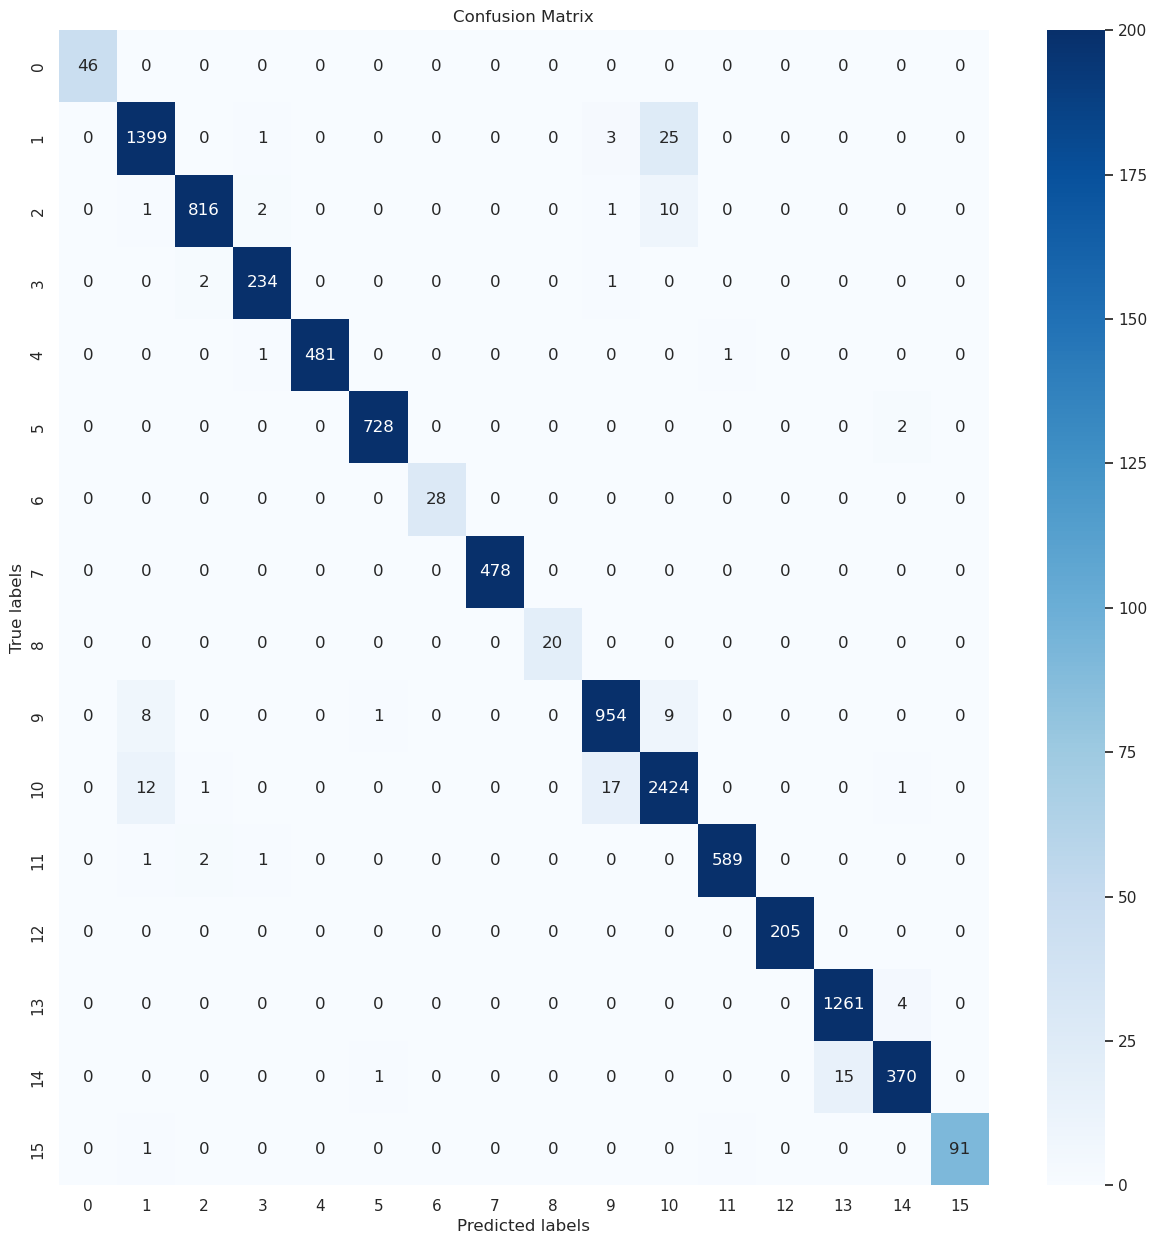

In [7]:
    # 绘制混淆矩阵图
    plt.figure(figsize=(15, 15))
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', vmin=0, vmax=200)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()